Data shape: (1532, 402, 355)


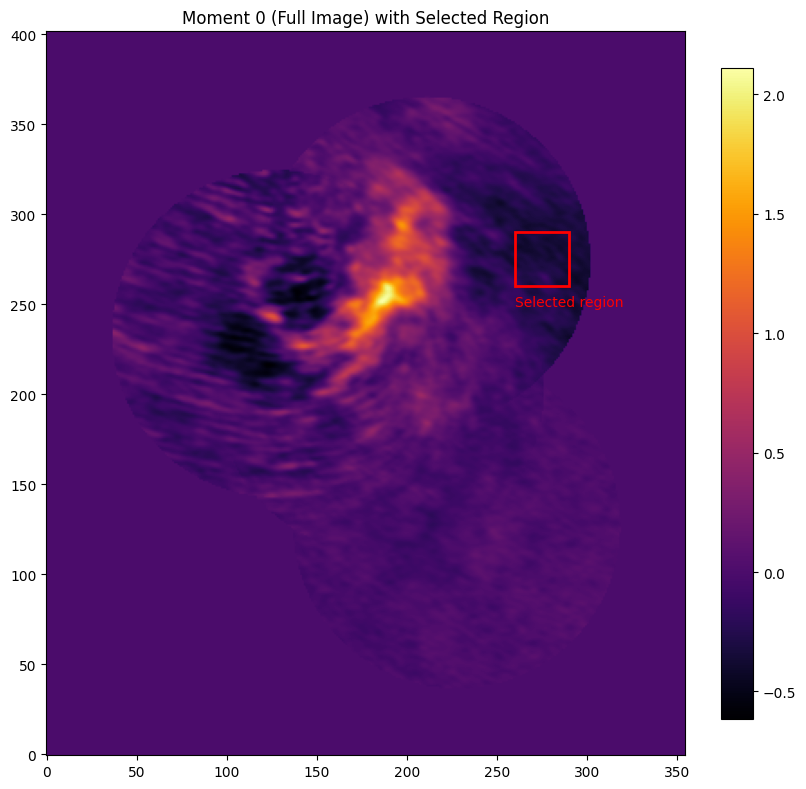

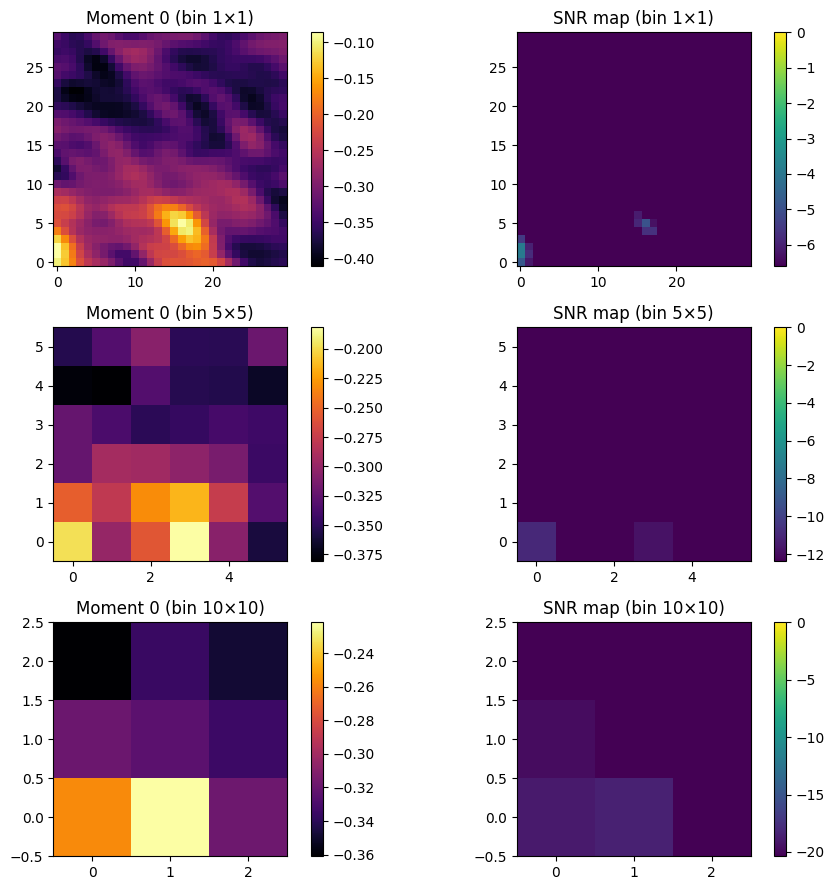

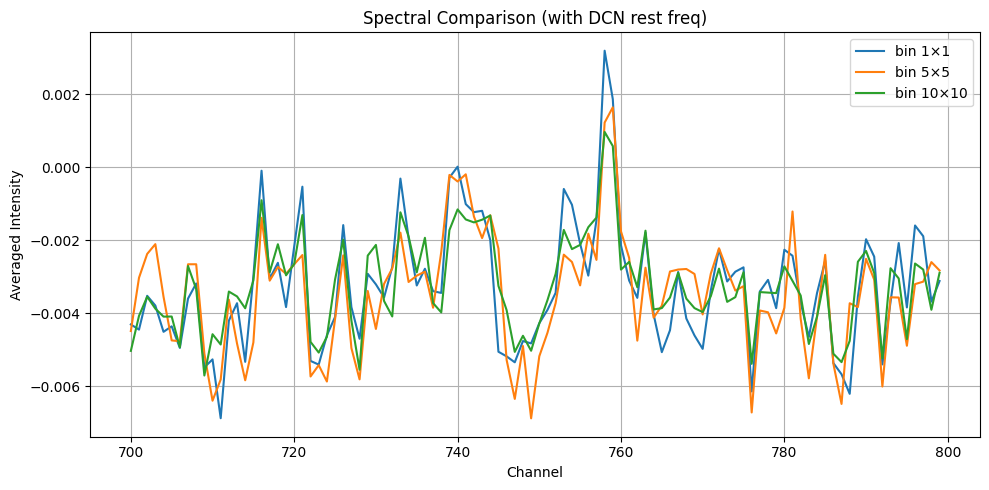

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import matplotlib.patches as patches

# ==== Set input file and channel range ====
cube_file = r"/Users/ccc/Desktop/research/baobab/ALMA_project/datacubes/spw0.fits"
v1, v2 = 700, 800  # Channel range to analyze (adjust as needed) #DCN channel is 784

# ==== Read FITS data ====
data = fits.getdata(cube_file)       # shape: (stokes, freq, y, x)
header = fits.getheader(cube_file)
cube = data[0, :, :, :]
print(f"Data shape: {cube.shape}")

# ==== Extract specified channel region ====
x1, x2 = 260, 290   # x range
y1, y2 = 260, 290   # y range

subcube = cube[v1:v2, y1:y2, x1:x2]  # shape: (n_chan, y, x)
channels = np.arange(v1, v2)         # Original channel numbers (for x-axis)

# ==== Binning function ====
def spatial_bin_cube(cube, bin_factor):
    freq, ny, nx = cube.shape
    new_ny = ny // bin_factor
    new_nx = nx // bin_factor
    cube = cube[:, :new_ny*bin_factor, :new_nx*bin_factor]
    reshaped = cube.reshape(freq, new_ny, bin_factor, new_nx, bin_factor)
    binned = reshaped.mean(axis=(2, 4))
    return binned

# ==== Set binning sizes ====
bin_sizes = [1, 5, 10]  # Adjust binning sizes as needed
moment0_maps = {}
snr_maps = {}

for b in bin_sizes:
    binned = subcube if b == 1 else spatial_bin_cube(subcube, b)
    moment0 = np.nansum(binned, axis=0)
    rms = np.nanstd(binned, axis=0) * np.sqrt(binned.shape[0]) # RMS calculation
    snr = moment0 / (rms + 1e-10) # Avoid division by zero
    moment0_maps[b] = moment0
    snr_maps[b] = snr

# ==== Show original Moment 0 map and draw selected region ====
moment0_full = np.nansum(cube[v1:v2, :, :], axis=0)
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(moment0_full, origin='lower', cmap='inferno')
plt.colorbar(im, ax=ax, fraction=0.046)
ax.set_title("Moment 0 (Full Image) with Selected Region")

# Draw the selected region
rect = patches.Rectangle(
    (x1, y1),           # Bottom-left coordinate (x, y)
    x2 - x1,            # Width
    y2 - y1,            # Height
    linewidth=2, edgecolor='red', facecolor='none'
)
ax.add_patch(rect)
ax.text(x1, y1-5, "Selected region", color='red', fontsize=10, va='top')
plt.tight_layout()
plt.show()

# ==== Show Moment 0 / SNR Map ====
fig, axes = plt.subplots(len(bin_sizes), 2, figsize=(10, 3*len(bin_sizes)))
for i, b in enumerate(bin_sizes):
    ax0, ax1 = axes[i]
    im0 = ax0.imshow(moment0_maps[b], origin='lower', cmap='inferno')
    ax0.set_title(f'Moment 0 (bin {b}×{b})')
    plt.colorbar(im0, ax=ax0, fraction=0.046)

    im1 = ax1.imshow(snr_maps[b], origin='lower', cmap='viridis',
                     vmin=0, vmax=np.nanpercentile(snr_maps[b], 99))
    ax1.set_title(f'SNR map (bin {b}×{b})')
    plt.colorbar(im1, ax=ax1, fraction=0.046)
plt.tight_layout()
plt.show()

# ==== Spectral comparison plot (channel as x-axis, with rest frequency marker) ====
fig, ax = plt.subplots(figsize=(10, 5))
ny, nx = subcube.shape[1:]
y0, x0 = ny // 2, nx // 2

for b in bin_sizes:
    if b == 1:
        cube_use = subcube
        roi = cube_use[:, y0 - 2:y0 + 3, x0 - 2:x0 + 3]  # Center 5x5
    else:
        cube_use = spatial_bin_cube(subcube, b)
        yb, xb = y0 // b, x0 // b
        roi = cube_use[:, yb:yb + 1, xb:xb + 1]

    spec = roi.mean(axis=(1, 2))
    ax.plot(np.arange(v1, v2), spec, label=f'bin {b}×{b}')

# ==== Add red line for DCN rest frequency channel ====
crval = header['CRVAL3']
cdelt = header['CDELT3']
crpix = header['CRPIX3']
restfreq = 217.238530e9  # Hz

channel_rest = crpix - crval / cdelt
rest_index = int(round(channel_rest - 1))  # Convert to Python index

if v1 <= rest_index < v2:
    ax.axvline(rest_index, color='r', linestyle='--', label='DCN rest freq (v=0)')

ax.set_xlabel("Channel")
ax.set_ylabel("Averaged Intensity")
ax.set_title("Spectral Comparison (with DCN rest freq)")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

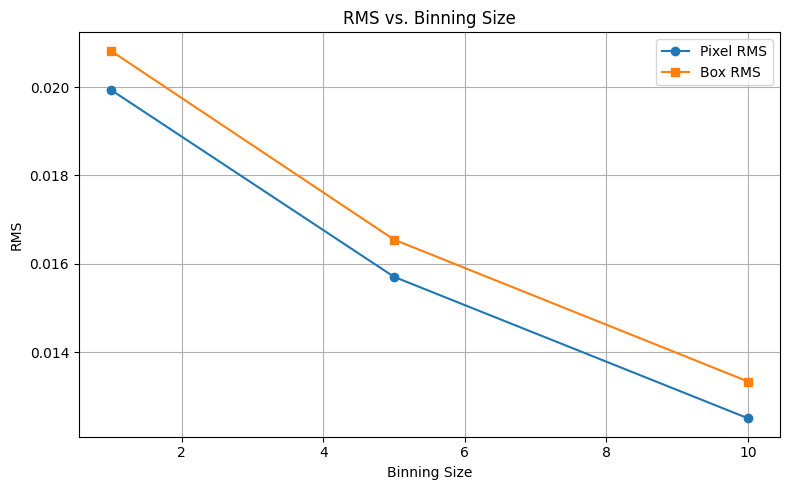

In [30]:
# ==== Plot RMS vs. Binning Size ====
# This section collects RMS values for different binning sizes and plots them.
# Collect RMS values for plotting
rms_pixel_list = []
rms_box_list = []

for b in bin_sizes:
    binned = subcube if b == 1 else spatial_bin_cube(subcube, b)
    moment0 = np.nansum(binned, axis=0)

    rms_pixel = np.nanstd(binned, axis=0) * np.sqrt(binned.shape[0])

    # Box RMS: use the originally selected region, adjust for binning
    if b == 1:
        box_region = binned[:, :, :]
    else:
        # Map original region to binned region
        y1b, y2b = 0, binned.shape[1]
        x1b, x2b = 0, binned.shape[2]
        box_region = binned[:, y1b:y2b, x1b:x2b]
    rms_box = np.nanstd(box_region) * np.sqrt(binned.shape[0])


    rms_pixel_list.append(np.nanmean(rms_pixel))
    rms_box_list.append(rms_box)
    snr = moment0 / (rms_pixel + 1e-10)
    moment0_maps[b] = moment0
    snr_maps[b] = snr

# Plot RMS diagram
plt.figure(figsize=(8, 5))
plt.plot(bin_sizes, rms_pixel_list, 'o-', label='Pixel RMS')
plt.plot(bin_sizes, rms_box_list, 's-', label='Box RMS')
plt.xlabel('Binning Size')
plt.ylabel('RMS')
plt.title('RMS vs. Binning Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()